<a href="https://colab.research.google.com/github/OlegMukminov/desktop-tutorial/blob/main/hometask_SyntheticRubber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##### При работе в Colab
!pip install yfinance requests

In [ ]:
import os
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [ ]:
# Для работы с API может потребоваться обходное решение для работы с SSL сертификатом
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

In [ ]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# formula - предпочитаемая формула расчета цены - скользящая средняя или среднее значение за месяц

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'formula':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'formula': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'formula': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'formula': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [ ]:
# Котировки натурального каучука доступны на сайте,  https://www.lgm.gov.my
# также у них есть API, пример запроса ниже
#
all_dfs=[]
for y in ['2019', '2020', '2021']:
  for m in ['01', '02']:
#year = '2022'
#month = '05'
    url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={m}&year={y}"
    res = requests.get(url)
    rj = res.json()
    temp_df = pd.json_normalize(rj)
    all_dfs.append(temp_df)

In [ ]:
df = pd.concat(all_dfs)

In [ ]:
df = df.set_index('date')

In [ ]:
df.head()

,grade,masa,rm,us,tone
date,,,,,
2019-01-31,SMR CV,Noon,770.00,191.30,Quiet
2019-01-31,SMR L,Noon,750.00,186.35,Quiet
2019-01-31,SMR 5,Noon,549.50,136.50,Quiet
2019-01-31,SMR GP,Noon,546.50,135.80,Quiet
2019-01-31,SMR 10,Noon,539.50,134.05,Quiet


In [ ]:
df = df.reset_index()

In [ ]:
df.date = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [ ]:
df.sort_values('date')

,date,grade,masa,rm,us,tone
140,2019-01-02,SMR CV,Noon,755.00,185.50,Quiet
146,2019-01-02,Latex in Bulk,Noon,381.00,381.00,Quiet
145,2019-01-02,SMR 20,Noon,526.00,129.25,Quiet
144,2019-01-02,SMR 10,Noon,528.00,129.75,Quiet
143,2019-01-02,SMR GP,Noon,535.00,131.45,Quiet
...,...,...,...,...,...,...
681,2021-02-26,SMR 5,Noon,749.50,187.65,Steady
680,2021-02-26,SMR L,Noon,1156.50,289.55,Steady
679,2021-02-26,SMR CV,Noon,1166.50,292.05,Steady
684,2021-02-26,SMR 20,Noon,737.50,184.65,Steady


In [ ]:
# PRICE_USD - цена в долларах за тонну коучука
# PRICE_USD_EU - цена в доллорах с учетом доставки в европу
#
df['PRICE_USD'] = pd.to_numeric(df['us'], downcast='float') * 1000 / 100
df['PRICE_USD_EU'] = df['PRICE_USD'] + EU_LOGISTIC_COST_EUR * 1.02
df['PRICE_USD_CN'] = df['PRICE_USD'] + CN_LOGISTIC_COST_USD
df['PRICE_USD_MA'] = df.PRICE_USD_EU.rolling(window=3).mean()

In [ ]:
df

,date,grade,masa,rm,us,tone,PRICE_USD,PRICE_USD_EU,PRICE_USD_CN,PRICE_USD_MA
0,2019-01-31,SMR CV,Noon,770.00,191.30,Quiet,1913.0,1943.599976,2043.0,NaN
1,2019-01-31,SMR L,Noon,750.00,186.35,Quiet,1863.5,1894.099976,1993.5,NaN
2,2019-01-31,SMR 5,Noon,549.50,136.50,Quiet,1365.0,1395.599976,1495.0,1744.433309
3,2019-01-31,SMR GP,Noon,546.50,135.80,Quiet,1358.0,1388.599976,1488.0,1559.433309
4,2019-01-31,SMR 10,Noon,539.50,134.05,Quiet,1340.5,1371.099976,1470.5,1385.099976
...,...,...,...,...,...,...,...,...,...,...
793,2021-02-02,SMR 5,Noon,653.50,164.20,Quietly Steady,1642.0,1672.599976,1772.0,2113.100057
794,2021-02-02,SMR GP,Noon,650.50,163.45,Quietly Steady,1634.5,1665.099976,1764.5,1886.100016
795,2021-02-02,SMR 10,Noon,643.50,161.70,Quietly Steady,1617.0,1647.599976,1747.0,1661.766642
796,2021-02-02,SMR 20,Noon,641.50,161.20,Quietly Steady,1612.0,1642.599976,1742.0,1651.766642


In [ ]:
df = df.groupby(['date']).mean()

In [ ]:
df

,PRICE_USD,PRICE_USD_EU,PRICE_USD_CN,PRICE_USD_MA
date,,,,
2019-01-02,1813.928589,1844.528564,1943.928589,1848.909517
2019-01-03,1833.785767,1864.385742,1963.785767,1874.147612
2019-01-04,1885.571411,1916.171387,2015.571411,1915.004755
2019-01-07,1885.285767,1915.885742,2015.285767,1924.171422
2019-01-08,1917.428589,1948.028564,2047.428589,1952.314279
...,...,...,...,...
2021-02-22,2629.357178,2659.957275,2759.357178,2679.861933
2021-02-23,2696.000000,2726.600098,2826.000000,2739.909552
2021-02-24,2728.214355,2758.814209,2858.214355,2799.195266


In [ ]:
df = df.loc['2019-06-30':'2022-06-30'].copy()
#df.loc['2019-06-30':'2022-06-30']

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

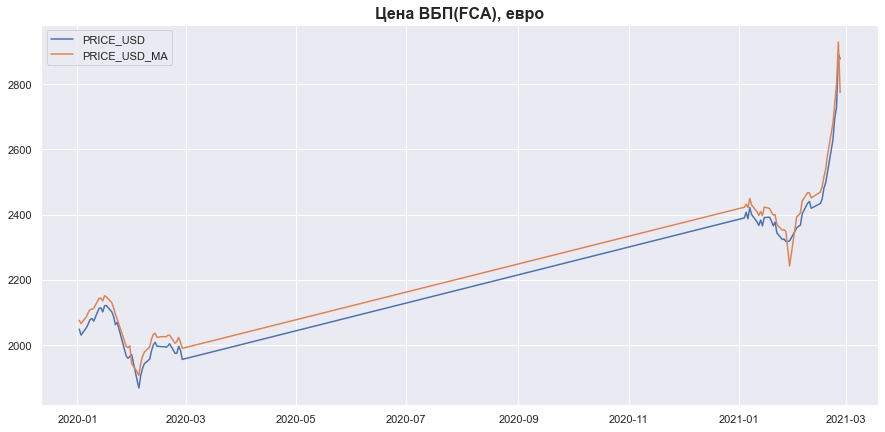

In [ ]:
# График с базовой ценой(на заводе) в евро
plt.title('Цена ВБП(FCA), евро', fontsize=16, fontweight='bold')
plt.plot(df['PRICE_USD'], label='PRICE_USD')
plt.plot(df['PRICE_USD_MA'], label='PRICE_USD_MA')
plt.legend()
plt.show()

In [ ]:
customers

{'Monty': {'location': 'EU', 'volumes': 200, 'formula': 'moving_average'},
 'Triangle': {'location': 'CN', 'volumes': 30, 'formula': 'monthly'},
 'Stone': {'location': 'EU', 'volumes': 150, 'formula': 'moving_average'},
 'Poly': {'location': 'EU', 'volumes': 70, 'formula': 'monthly'}}

In [ ]:
discounts = {100: 0.01, 300: 0.05, 301: 0.1}

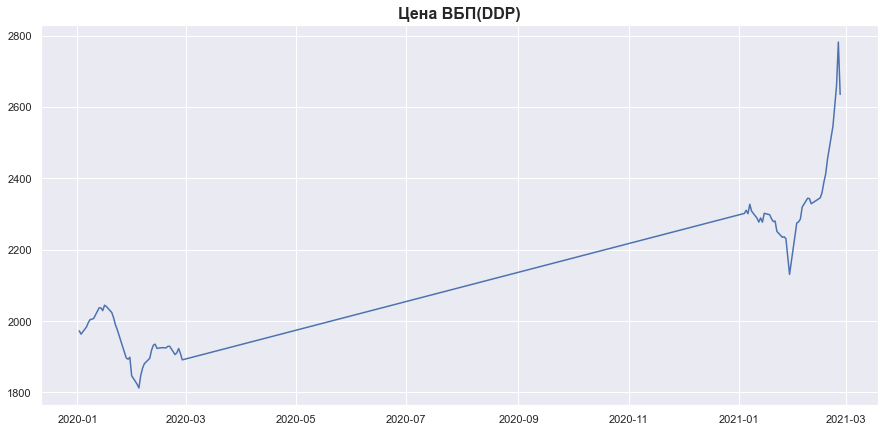

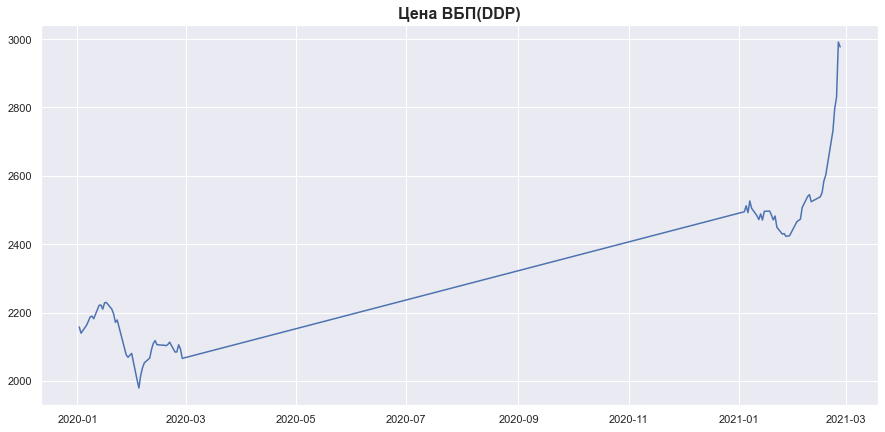

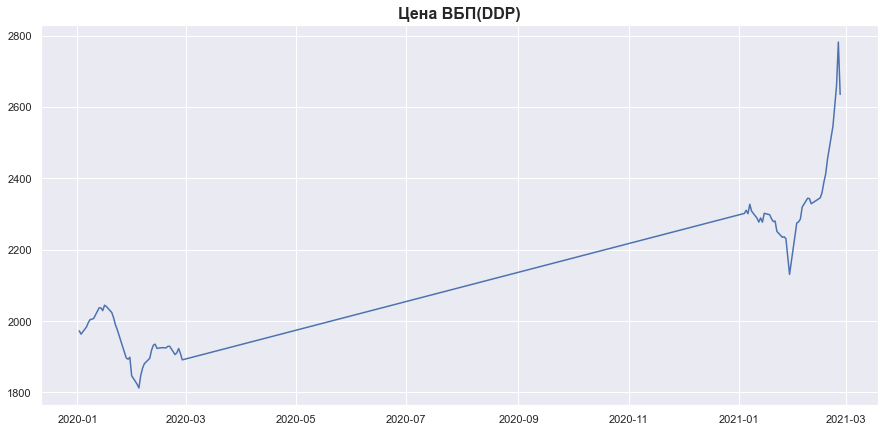

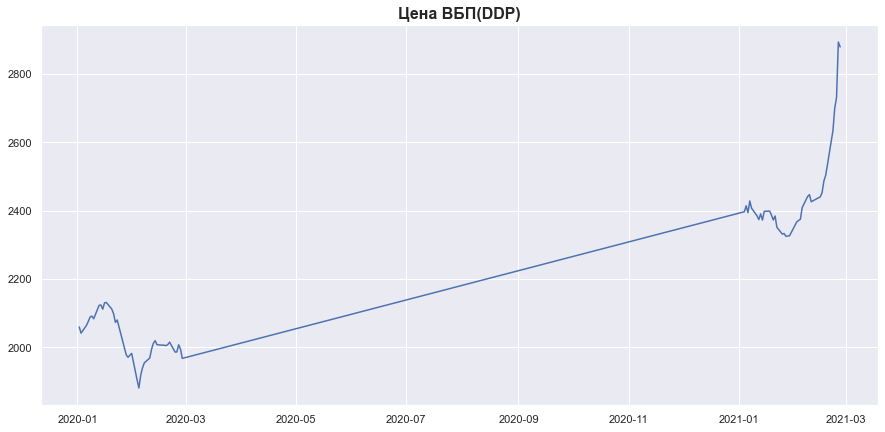

In [ ]:
with pd.ExcelWriter('price_proposals.xlsx', engine = 'xlsxwriter') as writer:
    for client, v in customers.items():
        disc = 0.0
        if v.get('location') == "EU":
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            if v.get('formula') == 'monthly':
                client_price = df['PRICE_USD_EU'] * (1-disc)
            elif v.get('formula') == 'moving_average':
                client_price = df['PRICE_USD_MA'] * (1-disc)

        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            client_price = df['PRICE_USD_CN'] * (1-disc)

        # print(client, v, disc)
        client_price.to_excel(writer, sheet_name=client)
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена ВБП(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        # worksheet = writer.sheets[client]
        # worksheet.insert_image('C2',plot_path)

    for k,v in customers.items():
        worksheet = writer.sheets[k]
        worksheet.insert_image('C2',f"{k}_wbp.png")

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

In [ ]:
# Создаем директорию для ценовых предложений клиентам
price_proposals_path = 'client_SyntheticRubber_price_proposals'
if not os.path.exists(price_proposals_path):
    os.mkdir(price_proposals_path)

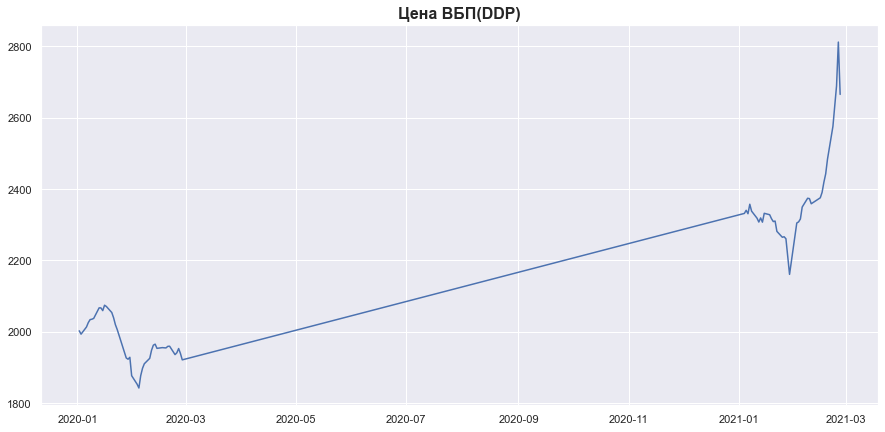

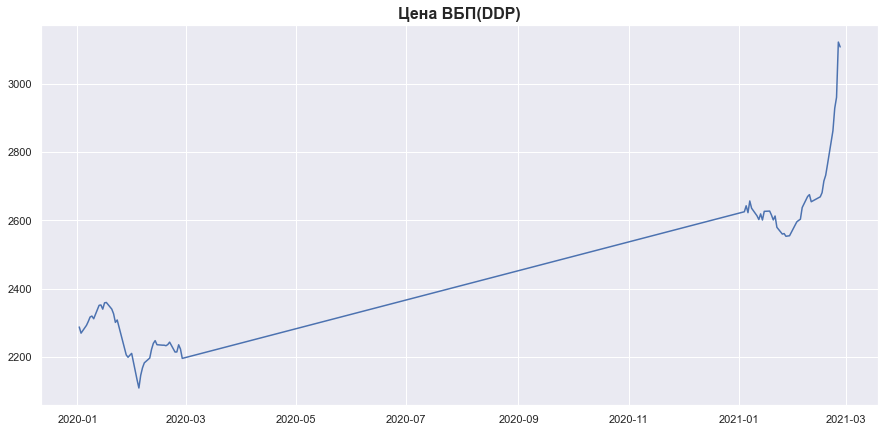

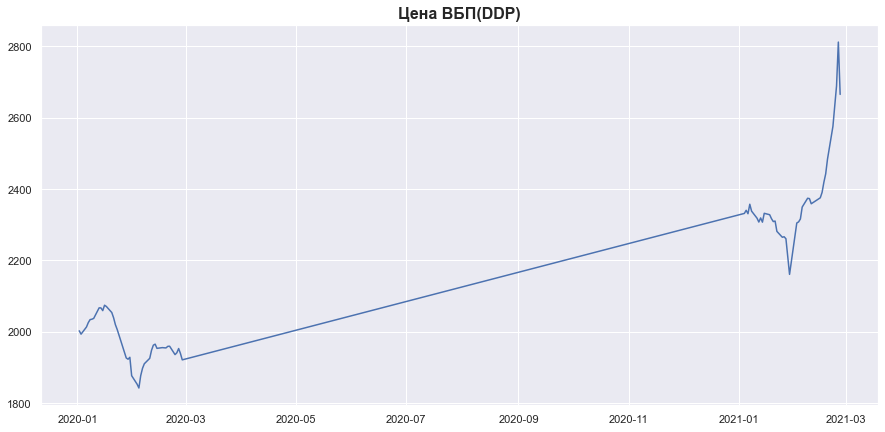

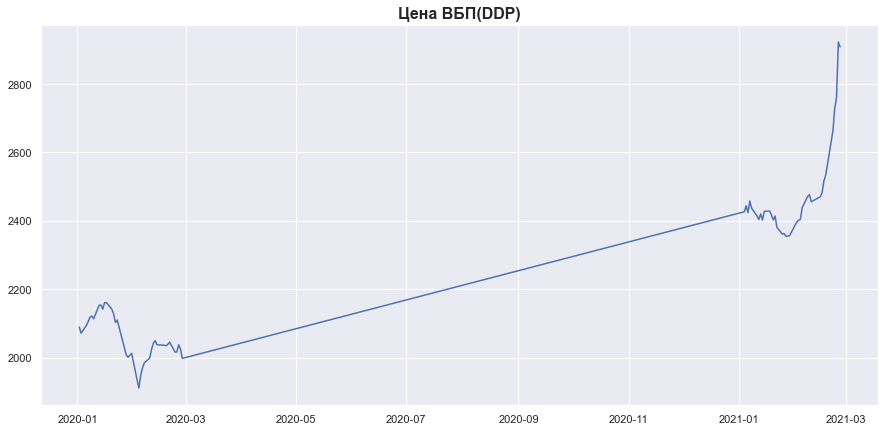

In [ ]:
# Создаем отдельный файл для каждого из клиентов
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_SyntheticRubber_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('formula') == 'monthly':
            client_price = df['PRICE_USD_EU'] * (1-disc) + EU_LOGISTIC_COST_EUR
        elif v.get('formula') == 'moving_average':
            client_price = df['PRICE_USD_MA'] * (1-disc) + EU_LOGISTIC_COST_EUR

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = df['PRICE_USD_CN'] * (1-disc) + CN_LOGISTIC_COST_USD
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена ВБП(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

# Задание 2. Продолжение

Клиенты согласились на ваше предложение.
### Что нужно сделать?
Вам нужно написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно.



* В результате должен быть скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

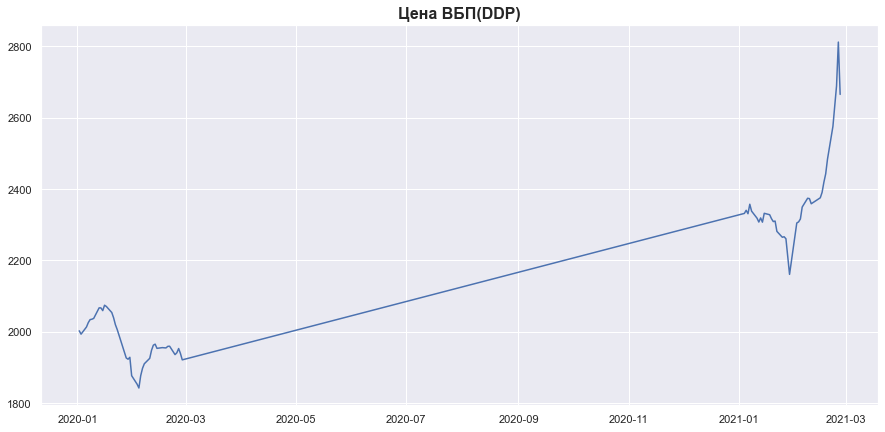

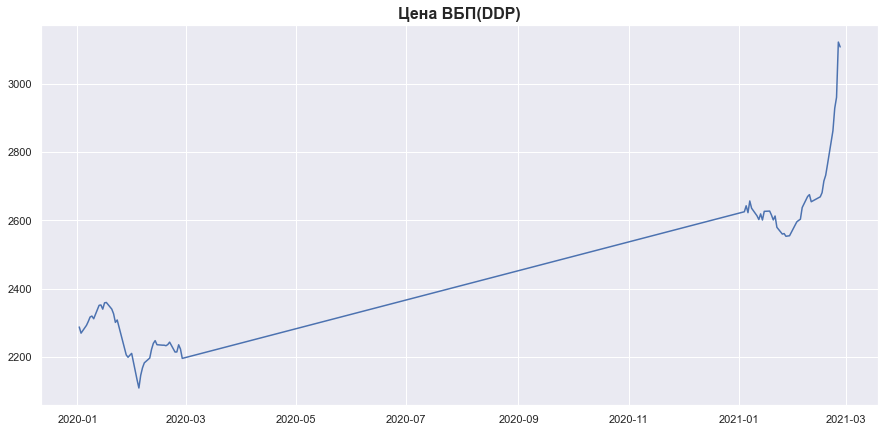

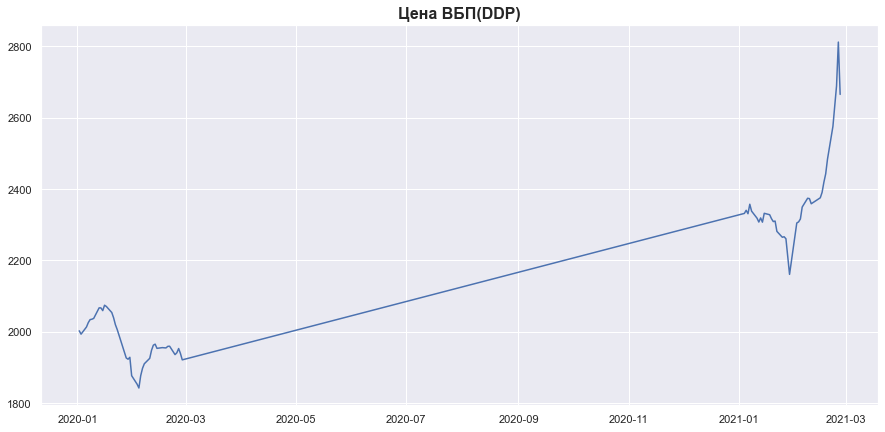

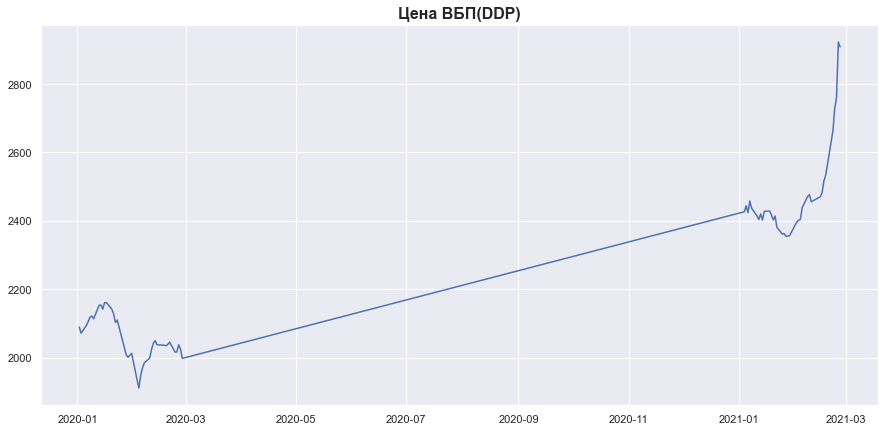

In [ ]:
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_SyntheticRubber_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('formula') == 'monthly':
            client_price = df['PRICE_USD_EU'] * (1-disc) + EU_LOGISTIC_COST_EUR
        elif v.get('formula') == 'moving_average':
            client_price = df['PRICE_USD_MA'] * (1-disc) + EU_LOGISTIC_COST_EUR

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = df['PRICE_USD_CN'] * (1-disc) + CN_LOGISTIC_COST_USD
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена ВБП(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

# Задание 3. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

### Что нужно сделать?
* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ
* Помните о PEP8

In [ ]:
from price_calculation_mod import calculate_prices

In [ ]:
import importlib

In [ ]:
calculate_prices()

hello world
Подгружаем котировки и курсы



Рассчитываем цены
Готовим отдельный файл для клиентов
date
2020-01-02    1898.90
2020-01-03    1890.03
2020-01-06    1909.03
2020-01-07    1920.65
2020-01-08    1928.64
Name: PRICE_USD_MA, dtype: float64
Monty готов
date
2020-01-02    2287.850098
2020-01-03    2269.810059
2020-01-06    2292.659912
2020-01-07    2303.969971
2020-01-08    2316.909912
Name: PRICE_USD_CN, dtype: float32
Triangle готов
date
2020-01-02    2002.72
2020-01-03    1993.36
2020-01-06    2013.42
2020-01-07    2025.68
2020-01-08    2034.12
Name: PRICE_USD_MA, dtype: float64
Stone готов
date
2020-01-02    2089.439941
2020-01-03    2071.409912
2020-01-06    2094.250000
2020-01-07    2105.560059
2020-01-08    2118.500000
Name: PRICE_USD_EU, dtype: float32
Poly готов
Удаляем ненужные файлы
Работа завершена!


# Задание 4. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

### Что нужно сделать?
* Создайте отдельный пакет, который можно устанавливать с помощью pip
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в свой репозиторий

In [ ]:
!pip install gelogus_paket
# import yourpackage

In [ ]:
from price_calculation_mod import calculate_prices

In [ ]:
calculate_prices()

hello world
Подгружаем котировки и курсы



Рассчитываем цены
Готовим отдельный файл для клиентов
date
2020-01-02    1898.90
2020-01-03    1890.03
2020-01-06    1909.03
2020-01-07    1920.65
2020-01-08    1928.64
Name: PRICE_USD_MA, dtype: float64
Monty готов
date
2020-01-02    2287.850098
2020-01-03    2269.810059
2020-01-06    2292.659912
2020-01-07    2303.969971
2020-01-08    2316.909912
Name: PRICE_USD_CN, dtype: float32
Triangle готов
date
2020-01-02    2002.72
2020-01-03    1993.36
2020-01-06    2013.42
2020-01-07    2025.68
2020-01-08    2034.12
Name: PRICE_USD_MA, dtype: float64
Stone готов
date
2020-01-02    2089.439941
2020-01-03    2071.409912
2020-01-06    2094.250000
2020-01-07    2105.560059
2020-01-08    2118.500000
Name: PRICE_USD_EU, dtype: float32
Poly готов
Удаляем ненужные файлы
Работа завершена!
